In [3]:
!pip install -U pyarrow polyleven -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 23.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 12.0.0 which is incompatible.


In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.2 MB/s eta 0:00:00


In [38]:
import pandas as pd
import io
import torch
from transformers import Pix2StructForConditionalGeneration, Pix2StructProcessor
import requests
from PIL import Image
import re
import numpy as np
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from transformers import DonutProcessor, VisionEncoderDecoderModel
from PIL import Image
import re
from collections import defaultdict
import statistics
import pandas as pd
import json
from glob import glob
from tqdm import tqdm
from polyleven import levenshtein 
import math

**Get model**

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = Pix2StructForConditionalGeneration.from_pretrained('google/deplot').to(device)
processor = Pix2StructProcessor.from_pretrained('google/deplot')

cuda


**Mounted Drive**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!rm -r dataset
!unzip /content/drive/MyDrive/miniProject/benetech-making-graphs-accessible.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/images/eaed09039206.jpg  
  inflating: dataset/train/images/eaed1e245167.jpg  
  inflating: dataset/train/images/eaedb251e670.jpg  
  inflating: dataset/train/images/eaeead418936.jpg  
  inflating: dataset/train/images/eaeeb1c2ecdd.jpg  
  inflating: dataset/train/images/eaef70ba842d.jpg  
  inflating: dataset/train/images/eaf036991cb3.jpg  
  inflating: dataset/train/images/eaf06e9e07db.jpg  
  inflating: dataset/train/images/eaf20f7d8945.jpg  
  inflating: dataset/train/images/eaf3a9a87868.jpg  
  inflating: dataset/train/images/eaf3d05d20a6.jpg  
  inflating: dataset/train/images/eaf3d24fb032.jpg  
  inflating: dataset/train/images/eaf3f734b5ce.jpg  
  inflating: dataset/train/images/eaf467f871a2.jpg  
  inflating: dataset/train/images/eaf65b4e3c45.jpg  
  inflating: dataset/train/images/eaf7f876411a.jpg  
  inflating: dataset/train/images/eafa35356cf8.jpg  
  inflating: dataset/train/images/eafa65caf8e7.j

**Helper Function**

In [10]:
def display_deplot_output(deplot_output):
    '''
    The raw output of deplot
    TITLE | Rural population (%) long-run with 2050 projections<0x0A>(OWID) in Greece<0x0A>Years | Rural population<0x0A>1940 | 47.38<0x0A>1960 | 43.68<0x0A>1980 | 30.28<0x0A>...
    '''
    
    deplot_output = deplot_output.replace("<0x0A>", "\n").replace(" | ", "\t")

    second_a_index = [m.start() for m in re.finditer('\t', deplot_output)][1]
    last_newline_index = deplot_output.rfind('\n', 0, second_a_index) 

    title = deplot_output[:last_newline_index]
    table = deplot_output[last_newline_index+1:]

    data = io.StringIO(table)
    df = pd.read_csv(data, sep='\t')
    # display(df)
    return df

def deplot(image, model, processor, device):
    
    # image = Image.open(path)
    # display(image)
    # Move inputs to GPU
    inputs = processor(images=image, text="Generate data", return_tensors="pt")
    inputs = {key: value.to(device) for key, value in inputs.items()}
    predictions = model.generate(**inputs, max_new_tokens=512)
    
    return processor.decode(predictions[0], skip_special_tokens=True)

In [12]:
image_path = "/content/horizontal_bar_graph_with_percentages_Slide01.jpg"
image = Image.open(image_path)

FileNotFoundError: ignored

In [ ]:
output = deplot(np.array(image),model,processor,device)

In [ ]:
display_deplot_output(output)

TITLE	Horizontal Bar Graph With Percentages


,Text Here,"This graph/chart is linked to excel, and changes automatically based on data. Just left click on it and select ""Edit Data."""
0,Text Here,95%
1,Text Here,80%
2,Text Here,70%
3,Text Here,50%
4,Text Here,30%
5,Text Here,15%
6,Text Here,35%
7,Text Here,20%


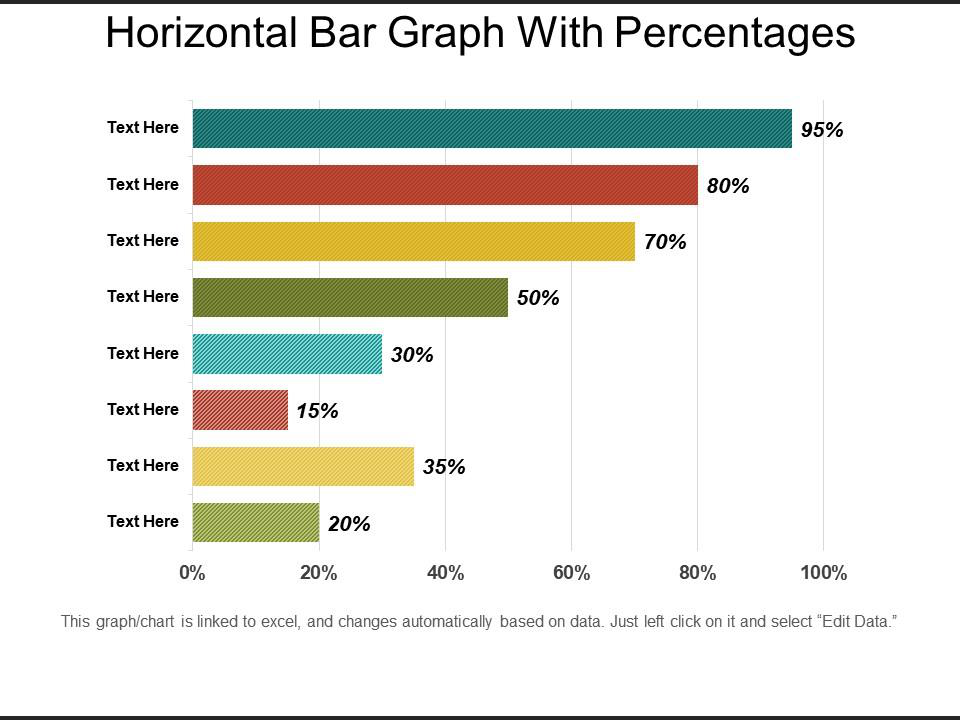

In [ ]:
image

**Benchmark Test**

In [13]:
from pathlib import Path

def is_nan(value):
     return isinstance(value, float) and str(value) == "nan"

def round_float(value):
    if isinstance(value, float):
        value = str(value)

        if "." in value:
            integer, decimal = value.split(".")
            if abs(float(integer)) > 1:
                decimal = decimal[:1]
            else:
                decimal = decimal[:4]

            value = integer + "." + decimal
    return value

def get_gt_string_and_xy(filepath):
    filepath = Path(filepath)

    with open(filepath) as fp:
        data = json.load(fp)
    if data['chart-type'] in ['scatter','vertical_bar','dot','line']:
       return None
    data_series = data["data-series"]

    all_x, all_y = [], []

    for d in data_series:
        x = d["x"]
        y = d["y"]

        x = round_float(x)
        y = round_float(y)

        # Ignore nan values
        if is_nan(x) or is_nan(y):
            continue

        all_x.append(x)
        all_y.append(y)
        
    

    return{
        "image_name" : str(filepath),
        "x": all_x,
        "y": all_y,
    }

In [14]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.subtract(y_true, y_pred))))

def sigmoid(x):
    return 2 - 2 / (1 + np.exp(-x))


def normalized_rmse(y_true, y_pred) -> float:
    numerator = rmse(y_true, y_pred)
    denominator = rmse(y_true, np.mean(y_true))

    if denominator == 0:
        if numerator == 0:
            return 1.0
        return 0.0

    return sigmoid(numerator / denominator)

def normalized_levenshtein_score(y_true, y_pred):
    total_distance = np.sum([levenshtein(yt, yp) for yt, yp in zip(y_true, y_pred)])
    length_sum = np.sum([len(yt) for yt in y_true])
    return sigmoid(total_distance / length_sum)

def score_series(y_true, y_pred):
    if len(y_true) != len(y_pred):
        return 0.0
    if isinstance(y_true[0], str):
        return normalized_levenshtein_score(y_true, y_pred)
    else:
        # Since this is a generative model, there is a chance it doesn't produce a float.
        # In that case, we return 0.0.
        try:
            return normalized_rmse(y_true, list(map(float, y_pred)))
        except:
            return 0.0

In [15]:
ANNOTATION = "/content/dataset/train/annotations/*.json"
ground_truth = []
for file_name in tqdm(glob(ANNOTATION)):
    res = get_gt_string_and_xy(file_name)
    if res == None:
       continue
    ground_truth.append(res)

100%|██████████| 60578/60578 [00:37<00:00, 1610.47it/s]


In [16]:
ground_truth[0]

{'image_name': '/content/dataset/train/annotations/fdc8e5c9ca09.json',
 'x': [0, 19, 24, 42, 17, 8, 4, 11],
 'y': ['Both Latin/a',
  'Both Asian',
  'Both Black',
  'Black man / White woman',
  'White man / Latina woman',
  'White man / Asian woman',
  'White man / Black woman',
  'Both white']}

In [48]:
res = []
for gt in tqdm(ground_truth):
    image_path = gt["image_name"]
    # try:
    image_path = "/content/dataset/train/images/" + image_path.split('/')[-1].replace('.json','.jpg')
    image = Image.open(image_path)
    # plt.imshow(image)
    # plt.show()
    df = display_deplot_output(deplot(np.array(image),model,processor,device))
    x_values = list(reversed(df[df.columns[1]].values))
    # x_values = [float(v.split('%')[0])/100 if "%" in str(v) else v for v in x_values]
    # x_values = [0 if math.isnan(float(ele)) else ele for ele in x_values ]
    y_values = [str(ele) for ele in list(reversed(df[df.columns[0]].values))]
    gt_x = [float(ele) for ele in gt['x']]
    gt_y = gt['y']
    # print("=========")
    # print(x_values)
    # print(gt_x)
    # print("=========")
    
    res_y = score_series(gt_y,y_values)
    res_x = score_series(gt_x,x_values)
    res.append([image_path,res_x,res_y])
    # except:
    #   res.append([image_path,0,0])
    #   image = Image.open(image_path)
    #   plt.imshow(image)
    #   plt.show()
    #   print("=========")
    #   print(x_values,y_values)
    #   print(gt_x,gt_y)
    #   print("=========")

100%|██████████| 73/73 [04:53<00:00,  4.02s/it]


In [49]:
res

[['/content/dataset/train/images/fdc8e5c9ca09.jpg',
  0.9885430429911641,
  0.9666790068611772],
 ['/content/dataset/train/images/173526fcff49.jpg',
  0.9687487293507353,
  0.9801788078468812],
 ['/content/dataset/train/images/6e11ee43f6a9.jpg', 0.0, 0.0],
 ['/content/dataset/train/images/f0ee6a02ebf7.jpg',
  0.9958619220502665,
  0.9659222914779813],
 ['/content/dataset/train/images/d7ec9803eb3b.jpg', 0.0, 0.0],
 ['/content/dataset/train/images/c2e87653de28.jpg',
  0.9931760986531439,
  0.9535218831188681],
 ['/content/dataset/train/images/ff02f480a5e3.jpg', 1.0, 0.9770155429862648],
 ['/content/dataset/train/images/d489b94f79e6.jpg',
  0.9838689347144922,
  0.9195292141805493],
 ['/content/dataset/train/images/e4b82a9e5214.jpg', 0.0, 0.0],
 ['/content/dataset/train/images/582d866854e0.jpg', 0.0, 0.0],
 ['/content/dataset/train/images/679dc4eee502.jpg', 0.0, 0.0],
 ['/content/dataset/train/images/f139abfed145.jpg', 1.0, 0.9533671803922998],
 ['/content/dataset/train/images/6737ada0656

In [50]:
df = pd.DataFrame(res)
df.columns = ["image_name","score_x","score_y"]
df.tail()

,image_name,score_x,score_y
68,/content/dataset/train/images/f74f8b586f73.jpg,0.000000,0.000000
69,/content/dataset/train/images/b3513a46bf1e.jpg,0.970442,0.957343
70,/content/dataset/train/images/dfd36a5cdbe8.jpg,0.980094,0.966229
71,/content/dataset/train/images/3ffc21fad1bd.jpg,0.984448,1.000000
72,/content/dataset/train/images/d52e57ac6bea.jpg,0.000000,0.000000


In [51]:
score_x = df['score_x'].to_list()
score_y = df['score_y'].to_list()

score_res1 = []
for i in range(len(score_x)):
    score = (score_x[i] + score_y[i])/2
    score_res1.append(score)

0.5395647485986174


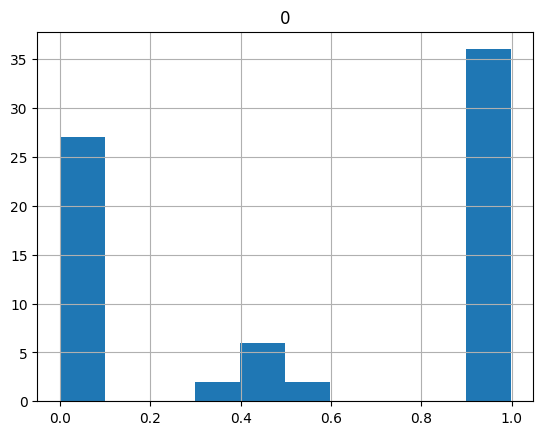

In [52]:
pd.DataFrame(score_res1).hist()
print(np.mean(score_res1))

0.5420481175180147


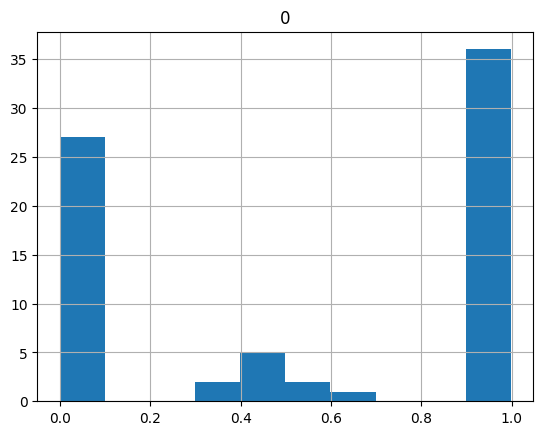

In [47]:
pd.DataFrame(score_res).hist()
print(np.mean(score_res))